In [1]:
import tarfile
from pathlib import Path
import urllib.request

def fetch_spam_data():
  spam_root = "http://spamassassin.apache.org/old/publiccorpus/"
  ham_url = spam_root + "20021010_easy_ham.tar.bz2"
  spam_url = spam_root + "20021010_spam.tar.bz2"

  spam_path = Path() / "datasets" / "spam"
  spam_path.mkdir(parents = True, exist_ok = True)
  for dir_name, tar_name, url in (("easy_ham", "ham", ham_url),
                                  ("spam","spam",spam_url)):
    if not (spam_path/dir_name).is_dir():
      path = (spam_path/tar_name).with_suffix(".tar.bz2")
      print("Downloading", path)
      urllib.request.urlretrieve(url,path)
      tar_bz2_file = tarfile.open(path)
      tar_bz2_file.extractall(path=spam_path)
      tar_bz2_file.close()
  return [spam_path/dir_name for dir_name in ("easy_ham", "spam")]

In [2]:
ham_dir, spam_dir = fetch_spam_data()

C:\Users\blaze\AppData\Local\Temp\ipykernel_31072\2248445629.py:19: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar_bz2_file.extractall(path=spam_path)


In [3]:
#iterate over files in dir and assigns paths strings to lists
ham_filenames = [f for f in sorted(ham_dir.iterdir()) if len(f.name)>20]
spam_filenames = [f for f in sorted(spam_dir.iterdir()) if len(f.name)>20]

In [4]:
len(ham_filenames)

2551

In [5]:
len(spam_filenames)

501

In [6]:
import email
from bs4 import BeautifulSoup
import email.policy


In [7]:
def parse_email(file_path):
  with open(file_path,'rb') as f:
    message = email.message_from_bytes(f.read())
  subject = message.get('Subject')
  body = message.get_payload()
  #if email body is multipart, join parts together firstly
  if isinstance(body, list):
    body=''.join(str(part) for part in body)
  #remove HTML tags from body, replaces \n characters with ' ' and returns it
  body_pretty = BeautifulSoup(body).get_text().replace('\n',' ')
  #removes any unecessary spaces by splitting the body into separate words and
  #joining them together
  body_pretty = ' '.join(body_pretty.split()).lower()
  final_msg = str(subject) + body
  return subject, body_pretty

In [8]:
spam = []
ham = []
spam = [parse_email(f) for f in spam_filenames]
ham = [parse_email(f) for f in ham_filenames]
spam.pop(0)
ham.pop(0)

('Re: New Sequences Window',
 'date: wed, 21 aug 2002 10:54:46 -0500 from: chris garrigues message-id: <1029945287.4797.tmda@deepeddy.vircio.com> | i can\'t reproduce this error. for me it is very repeatable... (like every time, without fail). this is the debug log of the pick happening ... 18:19:03 pick_it {exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace} {4852-4852 -sequence mercury} 18:19:03 exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace 4852-4852 -sequence mercury 18:19:04 ftoc_pickmsgs {{1 hit}} 18:19:04 marking 1 hits 18:19:04 tkerror: syntax error in expression "int ... note, if i run the pick command by hand ... delta$ pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace 4852-4852 -sequence mercury 1 hit that\'s where the "1 hit" comes from (obviously). the version of nmh i\'m using is ... delta$ pick -version pick -- nmh-1.0.4 [compiled on fuchsia.cs.mu.oz.au at sun mar 17 14:55:56 ict 2002] and the relevant part of my .mh_pro

In [ ]:
pip install langdetect

In [9]:
from langdetect import detect_langs, detect
def get_langs(text):
  try:
    return detect(text)
  except:
    return 'unknown'

ModuleNotFoundError: No module named 'langdetect'

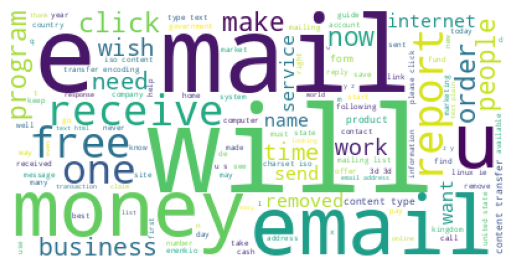

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

spam_body = [body for subject,body in spam]
spam_word = " ".join(spam_body)
wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white').generate(spam_word)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

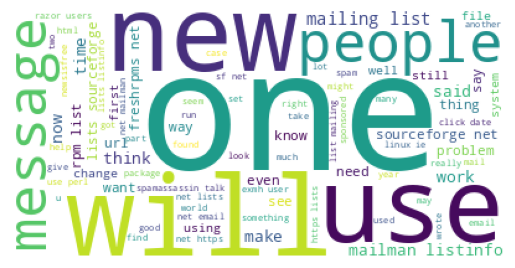

In [ ]:
ham_body = [body for subject,body in ham]
ham_word = " ".join(ham_body)
wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white').generate(ham_word)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
spam_filtered = [' '.join([word for word in email[1].split() if word.lower() not in stop_words]) for email in spam]
ham_filtered = [' '.join([word for word in email[1].split() if word.lower() not in stop_words]) for email in ham]

In [ ]:
spam_filtered[0]

"<= /tr> save 70% life insurance. spend to? life quote savings ensurin= g family's financial security important. life quote savings ma= kes buying life insurance simple affordable. provide free access = best companies lowest rates. life quote savings fast, eas= saves money! let us help get started best val= ues country new coverage. save hundreds even tho= usands dollars requesting free quote lifequote savings. = service take less 5 minutes complete. shop an= compare. save 70% types life insurance! click your= free quote! protecting family best investment eve= r make! receipt this= email error and/or wish removed list, please click type = remove. reside state prohibits e-mail solicitations insuran= ce, please disregard email.= center>"

In [ ]:
import pandas as pd
import numpy as np
ham_df = pd.DataFrame()
spam_df = pd.DataFrame()
ham_df["Spam?"] = np.zeros(len(ham))
ham_df["Message"] = ham_filtered
spam_df["Message"] = spam_filtered
spam_df["Spam?"] = np.ones(len(spam))
mails = pd.concat([ham_df,spam_df],ignore_index=True)

mails['Spam?'] = mails['Spam?'].astype(int)
mails['Message'] = mails['Message'].astype(str)

In [ ]:
langs = mails['Message'].apply(get_langs)

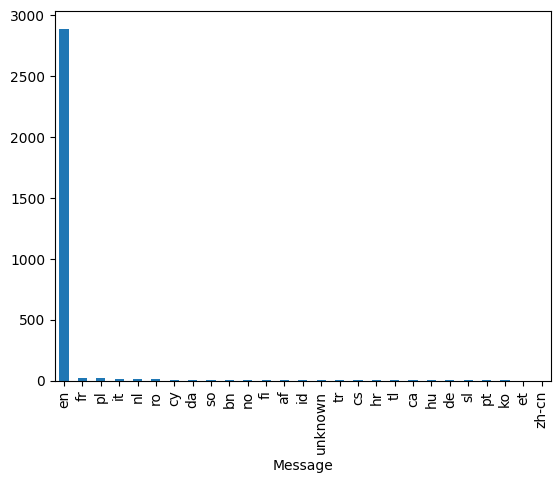

In [ ]:
langs.value_counts().plot(kind='bar')
mails['Language'] = langs

In [ ]:
pos = mails[mails["Language"]!='en'].index
only_en = mails.drop(index=pos)
mails = only_en.drop(["Language"], axis=1)

In [ ]:
mails.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2890 entries, 0 to 3049
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Spam?    2890 non-null   int64 
 1   Message  2890 non-null   object
dtypes: int64(1), object(1)
memory usage: 67.7+ KB


In [ ]:
import string
#convert url links -> URL
mails['Message'] = mails['Message'].str.replace('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 'URL').str.lower()
#replace numbers [0-9] -> NUMBER
mails['Message'] = mails['Message'].str.replace('[0-9]+','NUMBER', regex=True)
#create a translator: punctuation -> nothing
translator = str.maketrans(' ',' ',string.punctuation)
#remove punctuation
mails['Message'] = mails['Message'].str.translate(translator)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tokenized = tfidf.fit_transform(mails['Message']).toarray()

tokens = pd.DataFrame(tokenized, columns=tfidf.get_feature_names_out())
tokens['Spam?'] = mails['Spam?']

In [ ]:
tokens.head()


,0
aa,0
aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,0
aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaafgaccgnumbersfhoei,0
aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaafgaccgnumbersfhoeiiyql,0
aaabbgqydocgoqqhbvoiaadareccbkknumbereoghzmcydjowcwagaicontuaqadgcqybbsbobhaaweqc,0
...,...
écrit,0
écrite,0
élite,0
östersund,0


In [ ]:
from sklearn.model_selection import StratifiedKFold, train_test_split

mails_split = tokens.copy()
mails_split = mails_split.dropna(axis=0)
mails_labels = mails_split['Spam?'].copy()
mails_drop = mails_split.drop('Spam?',axis=1)

X_train,X_test,y_train,y_test = train_test_split(mails_drop,mails_labels,test_size = 0.2)

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

sgd = SGDClassifier(random_state=42)
param_distrib = {'loss': ['hinge','log_loss','percepton','squared_error'],
                 'alpha': uniform(0,0.001)}
random_search = RandomizedSearchCV(sgd,param_distributions=param_distrib,n_iter=3,
                                   cv=3,scoring='accuracy')
random_search.fit(X_train,y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [ ]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(random_state=42)

sgd.fit(X_train,y_train)

SGDClassifier(random_state=42)

In [ ]:
from sklearn.model_selection import cross_val_predict
y_pred = cross_val_predict(sgd,X_test,y_test,cv=3,method="decision_function")

In [ ]:
y_pred

array([-0.71386949, -1.94282158, -1.62750226, -2.03406051, -2.94086414,
       -1.31122616, -2.38203695, -2.70604451, -1.7954388 ,  1.69417227,
       -1.9327252 , -2.02473559,  2.51616228, -2.5415296 , -2.26064975,
       -1.53159349, -1.43513432, -1.50595843, -1.3738678 , -1.8557694 ,
       -0.84893151, -2.04591359, -3.15376531, -1.31807678, -2.03179885,
       -2.43121378, -1.28806699, -1.05979968, -1.56986331, -1.79842831,
       -1.47766347, -1.18680165, -1.68876704, -1.55893607, -2.18650869,
       -1.75403167, -2.24336597, -1.46220532, -1.28716504, -2.55360045,
       -1.18889237, -2.3965264 , -1.14974025,  0.26274193, -2.04697888,
       -0.98182649, -1.31942837, -0.51098675, -0.50736807, -1.6713712 ,
       -0.93697688, -1.67275978, -1.23152077, -1.35990433, -0.78046206,
       -1.22767644, -1.71962035,  3.04510731, -1.24072864, -0.66741382,
       -1.73239321, -1.07164193, -1.52896285, -2.13653424,  0.02706234,
       -1.38136701, -0.86675121, -1.1917102 , -1.73775062, -1.82